In [1]:
# imports
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline

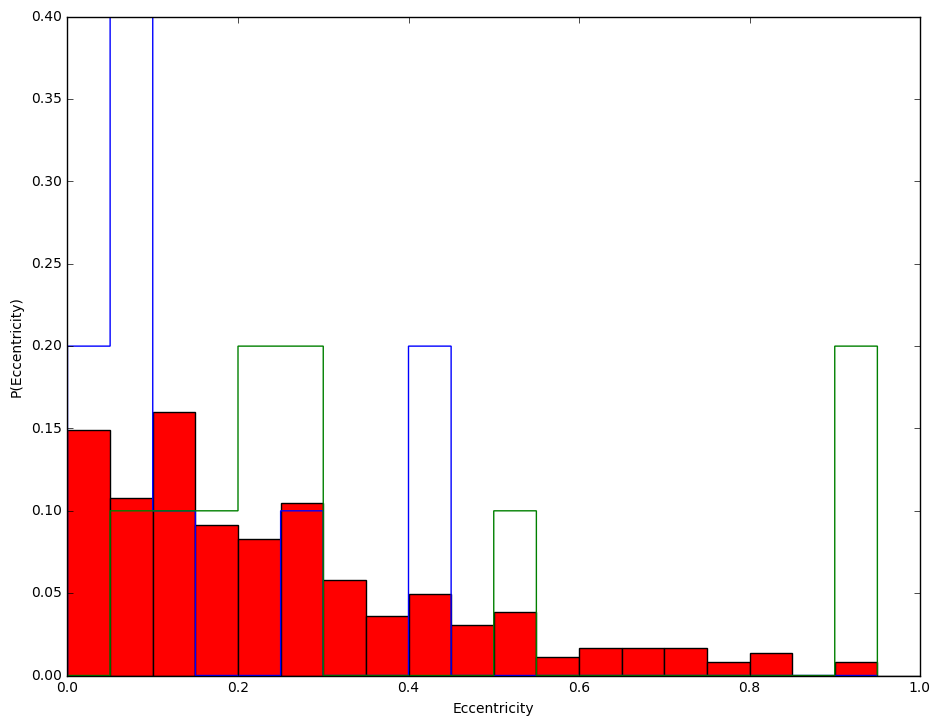

In [2]:
# now able to run entire notebook and produce the relevant parameters and figures.  

data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

t = 10 # number of sims to run

# generates list of ecc for b.in
n = 0
ecc_list_b = np.array([])
while n <= t-1:
    r = (np.random.sample(1)) #some y value (percentage)
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list_b=np.append(ecc_list_b,ecc)
    n += 1
    continue
ecc_hist_b = ax.hist(ecc_list_b,bins=x,weights=np.zeros_like(ecc_list_b)+1./ecc_list_b.size,histtype='step',color='blue')

# generates list of ecc for c.in
n = 0
ecc_list_c = np.array([])
while n <= t-1:
    r = (np.random.sample(1)) #some y value (percentage)
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list_c=np.append(ecc_list_c,ecc)
    n += 1
    continue
ecc_hist_c = ax.hist(ecc_list_c,bins=x,weights=np.zeros_like(ecc_list_c)+1./ecc_list_c.size,histtype='step',color='green')




R_crit = 2 * u.earthRad

# now to generate ICs and their files. 
# clears vars and generates new randoms
# b.in
mass_list_b = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
ecc_b = ecc_list_b
rad_list_b = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
Qp_b = np.array([]) # [30,300] # [10**6,10**7]
semi_b = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU

# c.in
mass_list_c = np.array([])
ecc_c = ecc_list_c
rad_list_c = np.random.uniform(0.5,10,25000) * u.earthRad
Qp_c = np.array([])
semi_c = np.random.uniform(0.01,0.15,25000)

# star.in
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]

# vpl.in
Ages = np.random.uniform(2*10**9,8*10**9,25000) # [2,8] Gyrs

# mass calculations
def calc_mass_l2(radius):
    r = radius
    mass = ((r/const.R_earth)**(3.68))*const.M_earth
    return mass

def calc_mass_g2(radius):
    r = radius
    r = r.to(u.cm)
    volume = (4*np.pi*r**3)/3
    density = (1*u.g)/(1*u.cm)**3
    mass = volume * density
    return mass

# determining mass and Qp based on radius; b.in
for r in rad_list_b:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list_b = np.append(mass_list_b,mass.value)
    Qp_b = np.append(Qp_b,Qplanet)


# determining mass and Qp based on radius; c.in    
for r in rad_list_c:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list_c = np.append(mass_list_c,mass.value)
    Qp_c = np.append(Qp_c,Qplanet)

        

rad_list_b = rad_list_b.value
rad_list_c = rad_list_c.value


3912 21088 25000


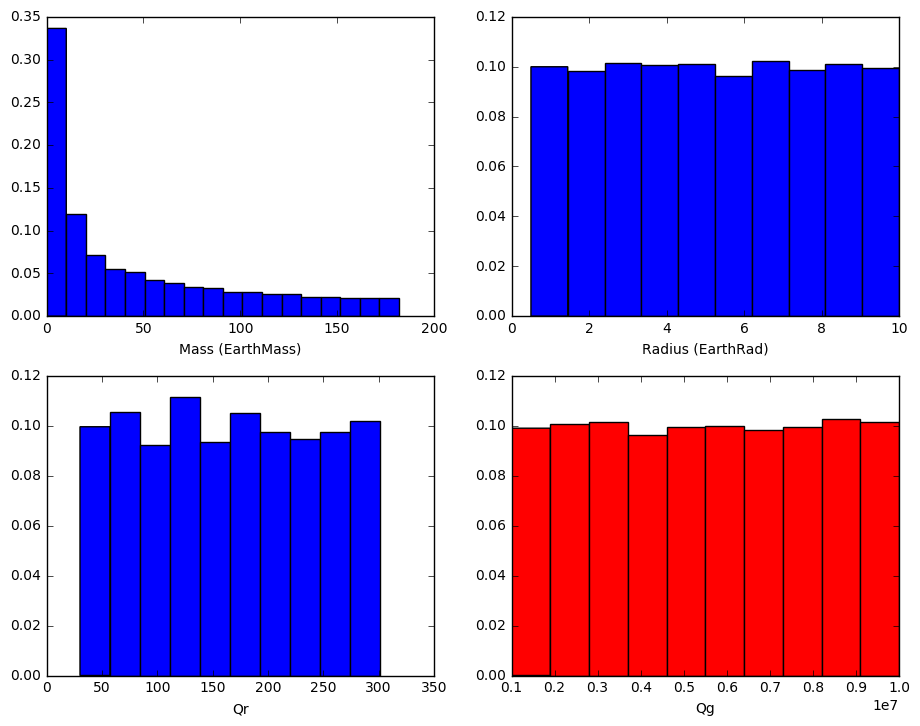

In [3]:
#distributions for b.in of mass,Qp, Radius
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list_b)-min(mass_list_b)
ax[0,0].hist(mass_list_b,bins=18,weights=np.zeros_like(mass_list_b)+1./mass_list_b.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_list_b,weights=np.zeros_like(rad_list_b)+1./rad_list_b.size) # Uniform
q_lower = np.where(Qp_b<=301)
q_upper = np.where(Qp_b>301) 
ax[1,0].hist(Qp_b[q_lower],weights=np.zeros_like(Qp_b[q_lower])+1./Qp_b[q_lower].size) 
ax[1,1].hist(Qp_b[q_upper],weights=np.zeros_like(Qp_b[q_upper])+1./Qp_b[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp_b[q_lower].size,Qp_b[q_upper].size,Qp_b[q_lower].size + Qp_b[q_upper].size)

4033 20967 25000


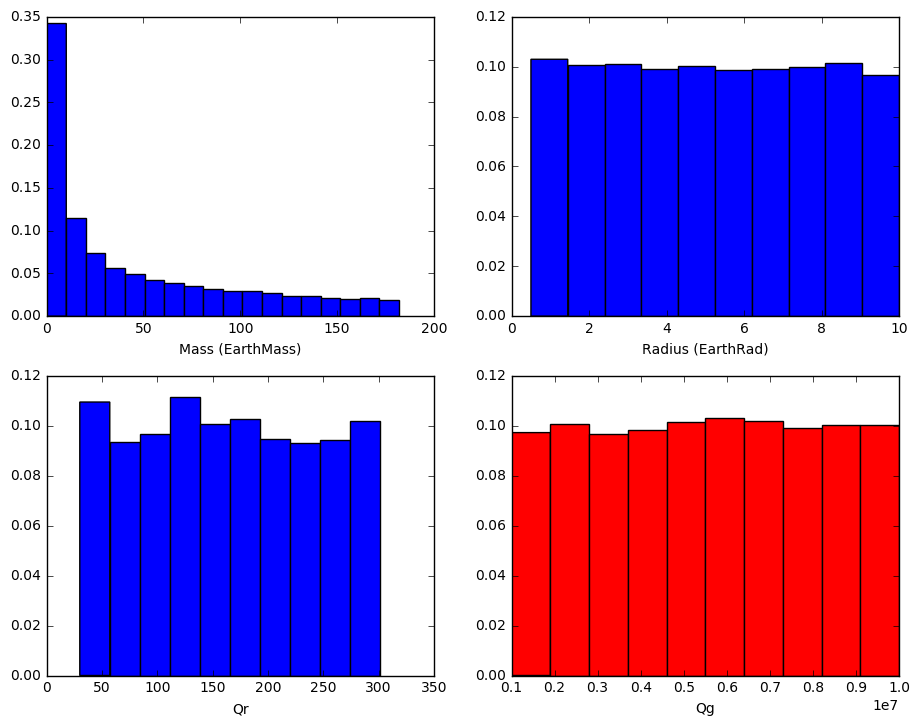

In [4]:
# distributions for c.in of mass, Qp, Radius. 
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list_c)-min(mass_list_c)
ax[0,0].hist(mass_list_c,bins=18,weights=np.zeros_like(mass_list_c)+1./mass_list_c.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_list_c,weights=np.zeros_like(rad_list_c)+1./rad_list_c.size) # Uniform
q_lower = np.where(Qp_c<=301)
q_upper = np.where(Qp_c>301) 
ax[1,0].hist(Qp_c[q_lower],weights=np.zeros_like(Qp_c[q_lower])+1./Qp_c[q_lower].size) 
ax[1,1].hist(Qp_c[q_upper],weights=np.zeros_like(Qp_c[q_upper])+1./Qp_c[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp_c[q_lower].size,Qp_c[q_upper].size,Qp_c[q_lower].size + Qp_c[q_upper].size)

In [21]:
# Parameters still need to do, by file
# b.in
name_b = 'b'
modules_b = 'eqtide'
sTideModel_b = 'p2'
dMass_b = (mass_list_b)*(-1) # sets to earth masses;
dRadius_b = (rad_list_b)*(-1) # sets to earth radii
bForceEqSpin_b = 1
#dRotPeriod = -1 
dObliquity_b = 0 
dRadGyra_b = 0.5
dTidalQ_b = Qp_b 
dK2_b = 0.3
#dMaxLockDiff = 0.1 
saTidePerts_b = 'star'
saOutputOrder_b = 'Time Semim Ecce'

# c.in
name_c = 'c'
modules_c = 'eqtide'
sTideModel_c = 'p2'
dMass_c = (mass_list_c)*(-1) # sets to earth masses; this isnt working!!
dRadius_c = (rad_list_c)*(-1) # sets to earth radii
bForceEqSpin_c = 1
#dRotPeriod = -1 
dObliquity_c = 0 
dRadGyra_c = 0.5
dTidalQ_c = Qp_c 
dK2_c = 0.3
#dMaxLockDiff = 0.1 
saTidePerts_c = 'star'
saOutputOrder_c = 'Time Semim Ecce'

#star.in
name_star = 'star'
modules_star = 'eqtide'
dMass_star = np.random.uniform(0.7,1.4,25000) #solar masses;
dRadius_star = dMass_star * 0.0048 # * ratio of solar radii to au
dObliquity_star = 0  
bForceEqSpin_star = 1
#dRotPeriod_star = -83 
dRadGyra_star = 0.5 
dTidalQ_star = 10**6
dK2_star = 0.3 
saTidePerts_star = 'b c'
saOutputOrder_s = 'Time'

#vpl.in
Sys_name = 'system'
iVerbose = 5
bOverwrite = 1
saBodyFiles = 'star.in b.in c.in'  
UnitMass = 'solar' 
UnitLength = 'aU'  
UnitTime = 'YEARS'
UnitAngle = 'd'
UnitTemp = 'K'
bDoLog = 1
iDigits = 6
dMinValue = 10**(-10)
bDoForward = 1
bVarDt = 1
dEta = 0.01
dStopTime = Ages
dOutputTime = 10**9

#hillstab.in; need to add mean anomoly
cent_mass = dMass_star
inner_mass = dMass_b * (-1) * u.earthMass
inner_mass = inner_mass.to(u.jupiterMass)
inner_mass = inner_mass.value
outer_mass = dMass_c * (-1) * u.earthMass
outer_mass = outer_mass.to(u.jupiterMass)
outer_mass = outer_mass.value
peri_inner = (1 - ecc_b)*semi_b #correct?
peri_outer = (1 - ecc_c)*semi_c #correct?

#any extra conversions for units defined in vpl.in; therefore everything needs to be in M_earth or R_earth.
print ('ICs set.')


ICs set.


In [ ]:
# now to filter which IC's follow Hill Inequality:
while s <= t-1:
    name_idx = '%05i'%s
    folder_name = name_idx
    working_directory = './runs/'+folder_name
    hillstab_run = '../../HillStability/hillstab/'
    p = subprocess.call([''], shell=True, cwd = working_directory)
    s += 1
    continue

In [19]:
shutil.rmtree('./runs/') # removes current runs; 

t = t # number of runs


n = 0
while n <= t-1: # will make n <= x amount of folders; (25000);
    # make strings of values; b.in
    name_idx = '%05i'%n
    mass_str_b = str(dMass_b[n]) 
    radius_str_b = str(dRadius_b[n])
    eqspin_str_b = str(bForceEqSpin_b)
    obl_str_b = str(dObliquity_b)
    radgy_str_b = str(dRadGyra_b)
    ecc_str_b = str(ecc_b[n])
    semi_str_b = str(semi_b[n])
    q_str_b = str(dTidalQ_b[n])
    dK2_str_b = str(dK2_b)
    perts_str_b = str(saTidePerts_b)
    outorder_str_b = str(saOutputOrder_b)
    #c.in
    mass_str_c = str(dMass_c[n]) 
    radius_str_c = str(dRadius_c[n])
    eqspin_str_c = str(bForceEqSpin_c)
    obl_str_c = str(dObliquity_c)
    radgy_str_c = str(dRadGyra_c)
    ecc_str_c = str(ecc_c[n])
    semi_str_c = str(semi_c[n])
    q_str_c = str(dTidalQ_c[n])
    dK2_str_c = str(dK2_c)
    perts_str_c = str(saTidePerts_c)
    outorder_str_c = str(saOutputOrder_c)
    
    #star.in
    name_star = name_star
    modules_star = modules_star
    strMass_str = str(dMass_star[n])
    strRad_str = str(dRadius_star[n])
    strObl_str = str(dObliquity_star)
    strEqSpin_str = str(bForceEqSpin_star)
    strRadGyr_str = str(dRadGyra_star)
    strTidalQ_str = str(dTidalQ_star)
    strdK2_str = str(dK2_star)
    saTidePerts_star = saTidePerts_star
    strsaOutputOrder = saOutputOrder_s
    #vpl.in
    sys_name = Sys_name
    iVerbose_str = str(iVerbose)
    bOverwrite_str = str(bOverwrite)
    saBodyFiles = saBodyFiles
    UnitMass = UnitMass
    UnitLength = UnitLength
    UnitTime = UnitTime
    UnitAngle = UnitAngle
    UnitTemp = UnitTemp
    bDoLog_str = str(bDoLog)
    iDigits_str = str(iDigits)
    dMinValue_str = str(dMinValue)
    bDoForward_str = str(bDoForward)
    bVarDt_str = str(bVarDt)
    dEta_str = str(dEta)
    dStopTime_str = str(int(dStopTime[n]))
    dOutputTime_str = str(dOutputTime)
    
    os.makedirs('./runs/'+name_idx)
    b = open('./runs/'+name_idx+'/b.in','w')
    b_content = 'sName\t'+ name_b + '\nsaModules\t'+modules_b+'\nsTideModel\t'+sTideModel_b+'\n\ndMass\t'+mass_str_b+'\ndRadius\t'+radius_str_b+'\ndObliquity\t'+obl_str_b+'\ndRadGyra\t'+radgy_str_b+'\n\ndEcc\t'+ecc_str_b+'\ndSemi\t'+semi_str_b+'\n\nbForceEqSpin\t'+eqspin_str_b+'\ndTidalQ\t'+q_str_b+'\ndK2\t'+dK2_str_b+'\nsaTidePerts\t'+perts_str_b+'\n\nsaOutputOrder\t'+outorder_str_b+'\n'
    b.write(b_content)
    b.close()
    
    c = open('./runs/'+name_idx+'/c.in','w')
    c_content = 'sName\t'+ name_c + '\nsaModules\t'+modules_c+'\n\ndMass\t'+mass_str_c+'\ndRadius\t'+radius_str_c+'\ndObliquity\t'+obl_str_c+'\ndRadGyra\t'+radgy_str_c+'\n\ndEcc\t'+ecc_str_c+'\ndSemi\t'+semi_str_c+'\n\nbForceEqSpin\t'+eqspin_str_c+'\ndTidalQ\t'+q_str_c+'\ndK2\t'+dK2_str_c+'\nsaTidePerts\t'+perts_str_c+'\n\nsaOutputOrder\t'+outorder_str_c+'\n'
    c.write(c_content)
    c.close()
    
    star = open('./runs/'+name_idx+'/star.in','w')
    star_content = 'sName\t'+name_star+'\nsaModules\t'+modules_star+'\n\ndMass\t'+strMass_str+'\ndRadius\t'+strRad_str+'\ndObliquity\t'+strObl_str+'\nbForceEqSpin\t'+strEqSpin_str+'\ndRadGyra\t'+strRadGyr_str+'\n\ndTidalQ\t'+strTidalQ_str+'\ndK2\t'+strdK2_str+'\n\nsaTidePerts\t'+saTidePerts_star+'\n\nsaOutputOrder\t'+strsaOutputOrder+'\n'
    star.write(star_content)
    star.close()
    
    vpl = open('./runs/'+name_idx+'/vpl.in','w')
    vpl_content = 'sSystemName\t'+sys_name+'\niVerbose\t'+iVerbose_str+'\nbOverwrite\t'+bOverwrite_str+'\n\nsaBodyFiles\t'+saBodyFiles+'\n\nsUnitMass\t'+UnitMass+'\nsUnitLength\t'+UnitLength+'\nsUnitTime\t'+UnitTime+'\nsUnitAngle\t'+UnitAngle+'\nsUnitTemp\t'+UnitTemp+'\n\nbDoLog\t'+bDoLog_str+'\niDigits\t'+iDigits_str+'\ndMinValue\t'+dMinValue_str+'\n\nbDoForward\t'+bDoForward_str+'\nbVarDt\t'+bVarDt_str+'\ndEta\t'+dEta_str+'\ndStopTime\t'+dStopTime_str+'\ndOutputTime\t'+ dOutputTime_str+'\n'
    vpl.write(vpl_content)
    vpl.close()
 
    n += 1
    

s = 0      #runs each simulation
while s <= t-1:
    name_idx = '%05i'%s
    folder_name = name_idx
    working_directory = './runs/'+folder_name
    p = subprocess.call(['vplanet vpl.in'], shell=True, cwd = working_directory)
    s += 1
    continue



print('Runs Completed')

Runs Completed
